B. Dataset description

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
from PIL import Image
import shap
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

c:\Users\giannos\Anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(folder_path):
    # load annotations
    annotations_path = os.path.join(folder_path, '_annotations.csv')
    annotations = pd.read_csv(annotations_path)
    
    data = []

    # load images based on filenames
    for index, row in annotations.iterrows():
        image_path = os.path.join(folder_path, row['filename'])
        if os.path.exists(image_path):
            with Image.open(image_path) as img:
                # read image
                image = img.copy()
            data.append({
                'image': image,
                'filename': row['filename'],
                'width': row['width'],
                'height': row['height'],
                'class': row['class'],
                'bbox': (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
            })
        else:
            print(f"Image {row['filename']} not found.")

    return data


train_data = load_data(r'C:\Users\giannos\Desktop\AI\train')
test_data = load_data(r'C:\Users\giannos\Desktop\AI\test')
valid_data = load_data(r'C:\Users\giannos\Desktop\AI\valid')

In this cell the function load data first loads the annotations file, then uses the filename column of annotations to load the specific image and saves in a list the image, its filename, the width, height, class , and bbox coordinates. This function is used to load train test and valid data from each file respectively.

In [3]:
df = pd.DataFrame(train_data+test_data+valid_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9283 entries, 0 to 9282
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     9283 non-null   object
 1   filename  9283 non-null   object
 2   width     9283 non-null   int64 
 3   height    9283 non-null   int64 
 4   class     9283 non-null   object
 5   bbox      9283 non-null   object
dtypes: int64(2), object(4)
memory usage: 435.3+ KB


Here we observe the whole dataset (train,test,valid sets). The dataset has 9283 samples and 7 features. The first feature is filename which isn't actually a feature but is used for loading the image that it corresponds to which is the actual feature. Each image is a 512x256 X-ray image of the mouth of a person that showcases their teeth. The second and third feature is the width and height which is usefull for the preprocessing procedures and have fix values of width=512 height=256. Then the other 4 features are the bounding box coordinates xmin, ymin, xmax, ymax that are all contained in the bbox column. It is lso important to note that each image from the dataset has multiple bounding boxes that characterize an object with its own classe label, thus each image has multiple classes and multiple bounding boxes coordinates.

In [4]:
unique_classes = df['class'].unique()
num_classes = len(unique_classes)

print(f"Number of classes: {num_classes}")
print("Classes found:", unique_classes)

Number of classes: 4
Classes found: ['Implant' 'Fillings' 'Impacted Tooth' 'Cavity']


This dataset includes dental X-ray images categorized into four unique classes: Implant, Fillings, Impacted Tooth, and Cavity. Each class represents a specific type of dental condition or observation that can be identified in the X-ray images. 

In [5]:
class_distribution = df['class'].value_counts()
num_samples = 9283
print(class_distribution)

if any(class_distribution < (num_samples / num_classes * 0.5)):
    print("\nThe dataset is unbalanced.")
else:
    print("\nThe dataset is relatively balanced.")

Fillings          6097
Implant           2047
Cavity             641
Impacted Tooth     498
Name: class, dtype: int64

The dataset is unbalanced.


In examining the dataset, it becomes evident that there is a significant class imbalance. Specifically, the "Fillings" class contains a disproportionately higher number of samples compared to the other classes, which could impact the learning process of the following models. Both the "Implant" and "Impacted Tooth" classes have notably fewer samples, nearly ten times less than that of the "Fillings" class. This disparity poses a challenge for machine learning algorithms, as it may skew the model's ability to accurately learn and generalize across less represented classes, potentially leading to biased predictions that favor the overrepresented class.

In [6]:
missing_values = df.isnull().sum()
print(missing_values)

image       0
filename    0
width       0
height      0
class       0
bbox        0
dtype: int64


Here we observe that the dataset has no missing values.

C. Dataset preprocessing

In [3]:

def augment_image(imge_dict, num_samples=4):
    augmented_images = []
    for image_dict in imge_dict:
        # if image_dict['class'] in ['Cavity', 'Impacted Tooth']:
        for _ in range(num_samples):
            image = np.array(image_dict['image'])
            xmin, ymin, xmax, ymax = image_dict['bbox']

            i=np.random.rand()
            # horizontal flip
            if  i < 0.33:
                aug = ImageDataGenerator(rescale=1./255)
                image = aug.apply_transform(image, {'rescale': 1./255, 'flip_horizontal': True})
                xmin, xmax = image_dict['width'] - xmax, image_dict['width'] - xmin

            # vertical flip
            elif np.random.rand() < 0.66:
                aug = ImageDataGenerator(rescale=1./255)
                image = aug.apply_transform(image, {'rescale': 1./255, 'flip_vertical': True})
                ymin, ymax = image_dict['height'] - ymax, image_dict['height'] - ymin
            else:
                aug = ImageDataGenerator(rescale=1./255)
                image = aug.apply_transform(image, {'rescale': 1./255}) 

            augmented_images.append({
                'image': image,
                'filename': image_dict['filename'],
                # 'width': image.width,
                # 'height': image.height,
                'class': image_dict['class'],
                'bbox': (xmin, ymin, xmax, ymax)
            })
        # else:
        #     image = np.array(image_dict['image'])
        #     xmin, ymin, xmax, ymax = image_dict['bbox']
        #     aug = ImageDataGenerator(rescale=1./255)
        #     image = aug.apply_transform(image, {'rescale': 1./255}) 
        #     augmented_images.append({
        #             'image': image,
        #             'filename': image_dict['filename'],
        #             # 'width': image.width,
        #             # 'height': image.height,
        #             'class': image_dict['class'],
        #             'bbox': (xmin, ymin, xmax, ymax)
        #         })
            
    return augmented_images

augmented_images = augment_image(train_data)
train_data = augmented_images

In the above code the function augment_image creates augmented images for the training set. The dataset becomes N times larger depending on the parameter num_samples.
The above function randomly flips the picture or remains the same with the result of creating a physical copy of the augmented image. It was also used to only augment the classes that had great imbalances in the dataset. Because this augmentation method had too much memory requirements and didn't increase the performance after several experiments it wasn't used in the following models.

In [2]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

Instead the ImageDataGenerator was used that randomly augments the train data upon called with flow() on the fit function of the models. This augmentation method doesn't create physical copies of each augmented dataset so it doesn't require much memory, instead we have different dataset in each training epoch, thus giving better generalition and being easier to use. This generator randomly shifts or flips or rotates each image differenlty in each epoch of the training so it creates multiple augmented inctances of the dataset. 

In [3]:
train_class_labels = [img_dict['class'] for img_dict in train_data]
valid_class_labels = [img_dict['class'] for img_dict in valid_data]
test_class_labels = [img_dict['class'] for img_dict in test_data]

label_encoder = LabelEncoder()

train_integer_encoded = label_encoder.fit_transform(train_class_labels)
valid_integer_encoded = label_encoder.fit_transform(valid_class_labels)
test_integer_encoded = label_encoder.fit_transform(test_class_labels)

# convert integer indices to one-hot encoding
train_labels = to_categorical(train_integer_encoded)
valid_labels = to_categorical(valid_integer_encoded)
test_labels = to_categorical(test_integer_encoded)

Here, the "class" column, originally containing string labels representing different dental conditions, is converted into integers. Following the integer encoding, one-hot encoding is applied to these integer labels across every set (training, validation, and testing). One-hot encoding transforms the integer-encoded labels into a binary matrix format, where each class label is represented as a binary vector. This method is particularly effective for handling categorical data and is essential for classification tasks in machine learning. By using one-hot encoding, the model can efficiently process the labels and precisely distinguish between the multiple classes, leading to better performance and accuracy in class prediction tasks.

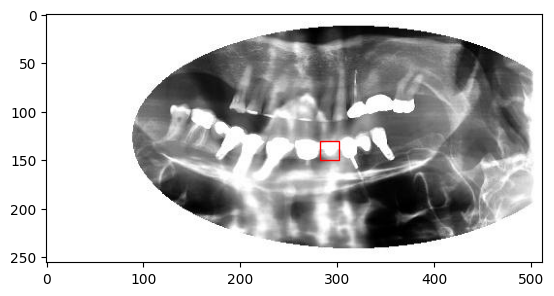

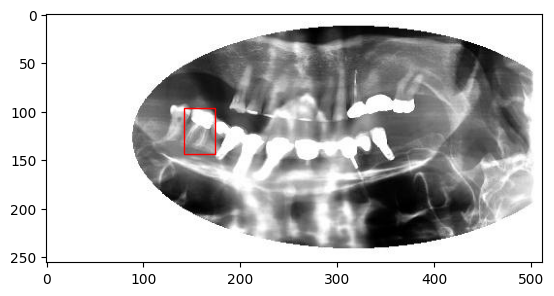

In [7]:
def display(image_dict):
    fig, ax = plt.subplots(1)
    # image display
    ax.imshow(image_dict['image'])

    # rectangle for bbox
    xmin, ymin, xmax, ymax = image_dict['bbox']
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

display(train_data[10])
display(train_data[8])

This function can be used for visualization purposes. It shows an X-ray image with its bounding box as a red rectangle. We can see now visually that each picture has multiple bounding boxes.

In [4]:
def resize_images(image_arrays, target_size):
    resized_images = []
    for img_array in image_arrays:
        resized_img = cv2.resize(img_array, target_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return np.array(resized_images)

def preprocess_images(images):
    image=images / 255.0
    return image

def resnet_preprocess_images(images):
    image = tf.keras.applications.resnet.preprocess_input(images)
    return image

def normalize_bboxes(bboxes):
    img_height=256
    img_width=512
    box=[[bbox[0]/img_width, bbox[1]/img_height, bbox[2]/img_width, bbox[3]/img_height] for bbox in bboxes]
    return np.array(box)

In this cell there are four functions.

The first one resize_images() changes the dimensions of each image to width=224, height=224, a common input size for many convolutional neural networks (CNNs). Resizing is fundamental to ensure that all images have the same shape and size, which is necessary for batch processing in neural network architectures.

The second preprocess_images() normalizes the pixel values of the images in range 0-1. Normalization is a critical preprocessing step used to convert pixel intensity values to a scale that contributes to a more stable and faster convergence during training by treating all input features uniformly. This function is specifically utilized for datasets that will train and validate custom models, helping them learn more efficiently from standardized data.
This function is only used for the sets that train and validate the CUSTOM model. 

The third resent_preprocess_images() changes the images in a format that is compatible with the resnet model. Specifically it changes the pictures in a format that is the same as the format the pictures that ResNet was trained on. This often includes specific transformations such as scaling pixel values in a certain way or applying specific mean subtraction and standard deviation normalization across RGB channels. This compatibility is crucial as it allows the pretrained model to perform optimally without having to relearn the basic patterns it was initially trained on. This function is only used for the data that will be used on the PRETRAINED models.

The fourth function normalize_bboxes() normalizes the bounding boxes in the range 0-1 so that it they can be used as outputs on the regression models bellow. This normalization aligns the bounding box dimensions with the scale of the images, irrespective of their original sizes. This step is essential for regression models used in object detection tasks, as it ensures that the model's output can be consistently interpreted across different image sizes and resolutions.

In [5]:
width=224
height=224

train_imgs = [np.array(img['image']) for img in train_data]
train_array = resize_images(train_imgs, target_size=(width, height))
train_images = resnet_preprocess_images(train_array)
#train_images = preprocess_images(train_array)

valid_imgs = [np.array(img['image']) for img in valid_data]
valid_array = resize_images(valid_imgs, target_size=(width, height))
valid_images = resnet_preprocess_images(valid_array)
#valid_images = preprocess_images(valid_array)

test_imgs = [np.array(img['image']) for img in test_data]
test_array = resize_images(test_imgs, target_size=(width, height))
test_images = resnet_preprocess_images(test_array)
#test_images = preprocess_images(test_array)

train_bbx = [img['bbox'] for img in train_data]
valid_bbx = [img['bbox'] for img in valid_data]
test_bbx = [img['bbox'] for img in test_data]

train_bboxes = normalize_bboxes(train_bbx)
valid_bboxes = normalize_bboxes(valid_bbx)
test_bboxes = normalize_bboxes(test_bbx)


# shuffle train data
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

train_images = train_images[indices]
train_bboxes = train_bboxes[indices]
train_labels = train_labels[indices]

In the above code the train, test and valid sets are preprocessed. The images of all sets are resized then preprocessed with resnet_preprocess_images on ResNet format to be available for training and validating the ResNet model. Then the bboxes of all sets are normalized. Finally the whole train set is randomly shuffled so that the order bias is reduced in training and we have better generalization. This cell and the next one are for the data that will be used on ResNet.

In [6]:
#paths that needs change

np.savez(r'C:\Users\giannos\Desktop\AI\resnet_train_data.npz', images=train_images, bboxes=train_bboxes, labels=train_labels)
np.savez(r'C:\Users\giannos\Desktop\AI\resnet_test_data.npz', images=test_images, bboxes=test_bboxes, labels=test_labels)
np.savez(r'C:\Users\giannos\Desktop\AI\resnet_valid_data.npz', images=valid_images, bboxes=valid_bboxes, labels=valid_labels)

Here I save the data that will be used on the ResNet model.

In [ ]:
width=224
height=224

train_imgs = [np.array(img['image']) for img in train_data]
train_array = resize_images(train_imgs, target_size=(width, height))
train_images = preprocess_images(train_array)

valid_imgs = [np.array(img['image']) for img in valid_data]
valid_array = resize_images(valid_imgs, target_size=(width, height))
valid_images = preprocess_images(valid_array)

test_imgs = [np.array(img['image']) for img in test_data]
test_array = resize_images(test_imgs, target_size=(width, height))
test_images = preprocess_images(test_array)

train_bbx = [img['bbox'] for img in train_data]
valid_bbx = [img['bbox'] for img in valid_data]
test_bbx = [img['bbox'] for img in test_data]

train_bboxes = normalize_bboxes(train_bbx)
valid_bboxes = normalize_bboxes(valid_bbx)
test_bboxes = normalize_bboxes(test_bbx)


# shuffle train data
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

train_images = train_images[indices]
train_bboxes = train_bboxes[indices]
train_labels = train_labels[indices]

This cell does the exact same preprocessing us the previous one with the only difference that it uses the preprocess_images function instead of resnet_preprocess_images to produce normalized images with values in the range of [0-1] that will be used on the Custom CNN model.

In [ ]:
#paths that needs change.

np.savez(r'C:\Users\giannos\Desktop\AI\cnn_train_data.npz', images=train_images, bboxes=train_bboxes, labels=train_labels)
np.savez(r'C:\Users\giannos\Desktop\AI\cnn_test_data.npz', images=test_images, bboxes=test_bboxes, labels=test_labels)
np.savez(r'C:\Users\giannos\Desktop\AI\cnn_valid_data.npz', images=valid_images, bboxes=valid_bboxes, labels=valid_labels)

Here each final preprocessed set for custom model is saved and later on loaded for each model.

With this save and loading of the data for each model the used Ram memory is reduced. When i reload the kernel and only load the preprocessed data later on I can utilize more resources on training the models.

D. Fine-tuning of a pre-trained model

In [ ]:
data = np.load(r'C:\Users\giannos\Desktop\AI\resnet_train_data.npz')
train_images = data['images']
train_bboxes = data['bboxes']
train_labels = data['labels']

data= np.load(r'C:\Users\giannos\Desktop\AI\resnet_test_data.npz')
test_images = data['images']
test_bboxes = data['bboxes']
test_labels = data['labels']

data = np.load(r'C:\Users\giannos\Desktop\AI\resnet_valid_data.npz')
valid_images = data['images']
valid_bboxes = data['bboxes']
valid_labels = data['labels']

In the above cell I load the train, valid and test images, class labels and bbox values that will be used on the ResNet model.

In [11]:
image_input = Input(shape=(224, 224, 3), name='image_input')


# load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
base_model.trainable = False # freeze layers

x = GlobalAveragePooling2D()(base_model.output)


FC1 = Dense(512, activation='relu')(x)
drop = Dropout(0.5)(FC1)
# FC2 = Dense(256, activation='relu')(FC1)
class_output = Dense(4, activation='softmax', name='class_output')(drop)

res_model = Model(inputs=image_input, outputs=class_output)
#print(model.summary())

res_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The ResNet50 pretrained model is used with frozen its layers to extract features from the input images. 

Then for the classification I use GlobalAveragePooling which condenses each feature map to a single scalar value, effectively reducing the dimensionality and focusing on the most salient features, a fully connected layer with 512 outputs to interpret these features and one more FC layer with softmax activation function to compute the propabilities of each class.
Also one Dropout layer is used. It acts as a form of regularization to prevent overfitting by randomly setting a fraction of input units to zero during training.

As optimizer I use Adam with default lr=0.01 and momentum=0, to produce fast and satisfactory results. Adam is favored for its adaptive learning rate capabilities, which allow it to converge faster and more effectively to the optimal weights.

The categorical crossentropy loss is computed which is compatible with one hot encoded labels, which is appropriate for models outputting probabilities across multiple classes and is ideal for scenarios involving one-hot encoded labels. Also the accuracy metric is display in each epoch to monitor the model's performance throughout the training process.

In [12]:
# fit model
res_model.fit(data_gen.flow(train_images, train_labels, batch_size=32), validation_data=(valid_images, valid_labels), epochs=8)

Epoch 1/8
251/251 [==============================] - 76s 288ms/step - loss: 1.0194 - accuracy: 0.6319 - val_loss: 0.8620 - val_accuracy: 0.6615
Epoch 2/8
251/251 [==============================] - 78s 311ms/step - loss: 0.8579 - accuracy: 0.6641 - val_loss: 0.8509 - val_accuracy: 0.6308
Epoch 3/8
251/251 [==============================] - 81s 323ms/step - loss: 0.8379 - accuracy: 0.6736 - val_loss: 0.8062 - val_accuracy: 0.6987
Epoch 4/8
251/251 [==============================] - 79s 313ms/step - loss: 0.8277 - accuracy: 0.6767 - val_loss: 0.7951 - val_accuracy: 0.6987
Epoch 5/8
251/251 [==============================] - 80s 320ms/step - loss: 0.8125 - accuracy: 0.6829 - val_loss: 0.8054 - val_accuracy: 0.6782
Epoch 6/8
251/251 [==============================] - 82s 327ms/step - loss: 0.8030 - accuracy: 0.6842 - val_loss: 0.8353 - val_accuracy: 0.6744
Epoch 7/8
251/251 [==============================] - 80s 317ms/step - loss: 0.7977 - accuracy: 0.6834 - val_loss: 0.8739 - val_accuracy:

In the above cell we see the training of the ResNet model in 8 epochs with batch size 32. The train data are randomly augmented with data_gen.flow() and are validated in each epoch with the validation set.

In [13]:
predictions = res_model.predict(test_images)
predicted_classes = predictions

predicted_class_indices = np.argmax(predicted_classes, axis=1)
true_class_indices = np.argmax(test_labels, axis=1)

accuracy = np.mean(predicted_class_indices == true_class_indices)
print("Classification accuracy: {:.2%}".format(accuracy))

f1 = f1_score(true_class_indices, predicted_class_indices, average='macro')
print("F1 Score: {:.2}".format(f1))

15/15 [==============================] - 3s 88ms/step
Classification accuracy: 67.65%
F1 Score: 0.28


Here the accuracy and f1 score are computed for this model using the test set for the final validation. The F1 score is the harmonic mean of precision and recall, making it an important metric when you need a balance between precision and recall, and there is an uneven class distribution. We can see that the model has above satisfactory results with 67.65% accuracy anf 28% f1 score. 
We can also see from the difference in the metrics and the pretty low f1 score that this dataset has great class imbalances and it affects the model too.

In [5]:
image_input = Input(shape=(224, 224, 3), name='image_input')


# load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
base_model.trainable = False # freeze layers

x = GlobalAveragePooling2D()(base_model.output)


FC1 = Dense(512, activation='relu')(x)
drop = Dropout(0.3)(FC1)
# FC2 = Dense(256, activation='relu')(drop)
bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(FC1)

model = Model(inputs=image_input, outputs=bbox_output)
#print(model.summary())

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

The above model is used for predicting the bounding box coordinates of the dataset. It is the same as the classification model with the exception that the final layer uses sigmoid activation function to predict the bounding box values instead of the propabilities of the classes. This change is crucial as the sigmoid function maps the output to a range between 0 and 1, which is ideal for predicting normalized coordinates of bounding boxes within an image. The output layer is specifically designed to predict four values per bounding box, corresponding to xmin, ymin, xmax, and ymax, each normalized relative to the image dimensions.

Also it uses the Adam optimizer for model optimization. While the optimizer remains the same as in the classification model, the loss function is switched to mean squared error (MSE) for this task. MSE is appropriate here as it effectively quantifies the average squared discrepancies between the predicted bounding box coordinates and the true values, making it sensitive to larger errors. I also employ mean absolute error (MAE) as a metric during training and evaluation phases. MAE provides a straightforward interpretation by measuring the average magnitude of errors in the bounding box predictions without considering their direction. 

In [6]:
model.fit(data_gen.flow(train_images, train_bboxes, batch_size=32), validation_data=(valid_images, valid_bboxes), epochs=5)

Epoch 1/5
251/251 [==============================] - 79s 284ms/step - loss: 0.1056 - mae: 0.2688 - val_loss: 0.0655 - val_mae: 0.2182
Epoch 2/5
251/251 [==============================] - 68s 270ms/step - loss: 0.0684 - mae: 0.2125 - val_loss: 0.0589 - val_mae: 0.2038
Epoch 3/5
251/251 [==============================] - 75s 297ms/step - loss: 0.0618 - mae: 0.2002 - val_loss: 0.0263 - val_mae: 0.1373
Epoch 4/5
251/251 [==============================] - 71s 281ms/step - loss: 0.0245 - mae: 0.1332 - val_loss: 0.0240 - val_mae: 0.1294
Epoch 5/5
251/251 [==============================] - 72s 286ms/step - loss: 0.0232 - mae: 0.1302 - val_loss: 0.0257 - val_mae: 0.1386


Here we have the same augmentation but we use as output y the bounding box values for both train and validation sets.
Also I use less epochs 5 to train this model as it seems it needs less to converge to a minimum loss.

In [7]:
predictions = model.predict(test_images)
predicted_bboxes = predictions

mse = mean_squared_error(test_bboxes, predicted_bboxes)
mae = mean_absolute_error(test_bboxes, predicted_bboxes)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

15/15 [==============================] - 2s 76ms/step
MSE: 0.0272
MAE: 0.1441


In the above cell MSE and MAE are calculated, using the test set for the final validation. An MSE of 0.0272 indicates that the squared deviations between predicted and actual values are relatively low on average, though this value can be influenced heavily by outliers due to the squaring of error terms. It suggests that the model, while generally accurate, may still have instances where the prediction significantly deviates from the actual values. Also an MAE of 0.1441 suggests that, on average, the absolute error in the predictions is moderate but slightly higher compared to the MSE.

E. Design you own model from scratch

In [5]:
data = np.load(r'C:\Users\giannos\Desktop\AI\cnn_train_data.npz')
train_images = data['images']
train_bboxes = data['bboxes']
train_labels = data['labels']

data= np.load(r'C:\Users\giannos\Desktop\AI\cnn_test_data.npz')
test_images = data['images']
test_bboxes = data['bboxes']
test_labels = data['labels']

data = np.load(r'C:\Users\giannos\Desktop\AI\cnn_valid_data.npz')
valid_images = data['images']
valid_bboxes = data['bboxes']
valid_labels = data['labels']

In the above cell I load the train, valid and test images, class labels and bbox values that will be used on the custom CNN model.

In [4]:
def create_model():
    inputs = Input(shape=(224, 224, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
   # with tf.device("cpu:0"):
    x = Dense(512, activation='relu')(x)

    class_output = Dense(4, activation='softmax', name='class_output')(x)

    model = Model(inputs=inputs, outputs=class_output)
    print(model.summary())

    return model


The above cell creates a CNN model for classification of the images. The model consists of three Conv2D layers with output channels 32,64 and 128. Each Conv2D layer uses the 'relu' activation function, known for its effectiveness in introducing non-linearity to the model while mitigating the vanishing gradient problem. Following each convolution layer, a MaxPooling layer is employed to reduce the spatial dimensions of the feature maps by half. This reduction not only decreases the computational load and model complexity but also helps in extracting the dominant features while reducing the risk of overfitting.
After extracting the features from the convolution layers I use a Dropout layer to reduce overfitting and a Flatten layer to produce one feature vector. Next for the classification I employ a Dense layer with 512 output channels and a Dense layer with 'softmax' activation function.

As optimizer I use Adam with default lr=0.01 and momentum=0. This setup is intended to yield rapid and effective convergence to optimal weights.

The categorical crossentropy loss is computed and the accuracy metric is calculated in each epoch.

In [5]:
custom_model = create_model()
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

Here each layer of the custom CNN model is displayed along with the output dimensions and the parameters. The output dimensions indicate the shape of the data as it progresses through each layer, which is crucial for understanding how the input image is transformed as it passes through the network. The parameters for each layer refer to the weights and biases that the model learns during training.

This model has 51,476,036 trainable parameters. Trainable parameters are those that are adjusted through backpropagation during the training process to minimize the loss function. A high number of parameters typically implies a more complex model that can capture intricate patterns.

In [8]:
custom_model.fit(data_gen.flow(train_images, train_labels, batch_size=32),
          validation_data=(valid_images, valid_labels), epochs=8)

Epoch 1/8
251/251 [==============================] - 83s 331ms/step - loss: 0.8694 - accuracy: 0.6725 - val_loss: 0.8656 - val_accuracy: 0.6679
Epoch 2/8
251/251 [==============================] - 69s 274ms/step - loss: 0.8527 - accuracy: 0.6741 - val_loss: 0.8647 - val_accuracy: 0.6859
Epoch 3/8
251/251 [==============================] - 71s 281ms/step - loss: 0.8474 - accuracy: 0.6747 - val_loss: 0.8174 - val_accuracy: 0.6859
Epoch 4/8
251/251 [==============================] - 77s 308ms/step - loss: 0.8238 - accuracy: 0.6796 - val_loss: 0.8349 - val_accuracy: 0.6923
Epoch 5/8
251/251 [==============================] - 75s 299ms/step - loss: 0.8162 - accuracy: 0.6795 - val_loss: 0.8746 - val_accuracy: 0.6744
Epoch 6/8
251/251 [==============================] - 72s 285ms/step - loss: 0.8033 - accuracy: 0.6842 - val_loss: 0.8147 - val_accuracy: 0.6821
Epoch 7/8
251/251 [==============================] - 71s 284ms/step - loss: 0.7971 - accuracy: 0.6878 - val_loss: 0.8230 - val_accuracy:

In the above cell we see the training of the CNN model in 8 epochs with batch size 32. The train data are randomly augmented with data_gen.flow() and are validated in each epoch with the validation set.

In [10]:
predictions = custom_model.predict(test_images)
predicted_classes = predictions

predicted_class_indices = np.argmax(predicted_classes, axis=1)
true_class_indices = np.argmax(test_labels, axis=1)

accuracy = np.mean(predicted_class_indices == true_class_indices)
print("Classification accuracy: {:.2%}".format(accuracy))

f1 = f1_score(true_class_indices, predicted_class_indices, average='macro')
print("F1 Score: {:.2}".format(f1))

15/15 [==============================] - 1s 31ms/step
Classification accuracy: 70.61%
F1 Score: 0.44


After calculating the 70.61% accuracy and 44% F1 score, using the test set for the final validatio,n we can see that the custom CNN model has better performance than the pretrained one mostly because it is customized to this specific dataset. Still the class imbalances are showcased by the low f1 score.

In [4]:
def create_model():
    inputs = Input(shape=(224, 224, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
   # with tf.device("cpu:0"):
    x = Dense(512, activation='relu')(x)

    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

    model = Model(inputs=inputs, outputs=bbox_output)
    #print(model.summary())

    return model

model = create_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

This is the regression custom CNN model. It has the same layers for the feature extraction as the classification model. The only difference is the last classification layer that uses sigmoid activation function to predict the bbox coordinates.

Also the model is optimized with Adam optimizer and in each epoch the Mean Squared Error(MSE) and Mean Absolute Error(MAE) is computed.

In [9]:
model.fit(data_gen.flow(train_images, train_bboxes, batch_size=32),
          validation_data=(valid_images, valid_bboxes), epochs=5)


Epoch 1/5
251/251 [==============================] - 75s 295ms/step - loss: 0.0209 - mae: 0.1254 - val_loss: 0.0206 - val_mae: 0.1244
Epoch 2/5
251/251 [==============================] - 71s 283ms/step - loss: 0.0209 - mae: 0.1254 - val_loss: 0.0202 - val_mae: 0.1232
Epoch 3/5
251/251 [==============================] - 70s 281ms/step - loss: 0.0209 - mae: 0.1254 - val_loss: 0.0202 - val_mae: 0.1232
Epoch 4/5
251/251 [==============================] - 71s 281ms/step - loss: 0.0209 - mae: 0.1254 - val_loss: 0.0204 - val_mae: 0.1238
Epoch 5/5
251/251 [==============================] - 72s 287ms/step - loss: 0.0209 - mae: 0.1254 - val_loss: 0.0204 - val_mae: 0.1237


Here we have augmentation of the training data and we use as output y the bounding box values for both train and validation sets.
Also I use less epochs 5 to train this model as it seems it needs less to converge to a minimum loss.

In [13]:
predictions = model.predict(test_images)
predicted_bboxes = predictions

mse = mean_squared_error(test_bboxes, predicted_bboxes)
mae = mean_absolute_error(test_bboxes, predicted_bboxes)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

15/15 [==============================] - 1s 88ms/step
MSE: 0.0215
MAE: 0.1264


A low MSE value of 0.0215, indicates that the model's predictions are close to the true data points, with relatively small errors on average but because MSE is squared, even relatively small deviations can seem larger. So I calculate MAE of 0.1264 that indicates the absolute difference on average between the predicted and actual bounding box coordinates is about 0.1264. This metric provides a more direct interpretation of average error magnitude. Overall the model shows better results in predicting the bounding boxes from the pretrained ResNet model.

F. Explainability (Bonus question)

In [45]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.get_layer(classifier_layer_names).output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

For the explainability I used the custom gradcam_heatmap function which generates a heatmap using the gradients of the target class with respect to the output feature map of the last convolutional layer of the model.

Then the function display_gradcam displays the heatmap on top of the image. Just to showcase the functionality two heatmaps are produced from the classification pretrained model with two pictures of the test set. The first picture has mostly 'Fillings' classes and the second has only 'Cavity' classes. This way we can observe how well the model performs on two new and different from each other pictures with different classes.

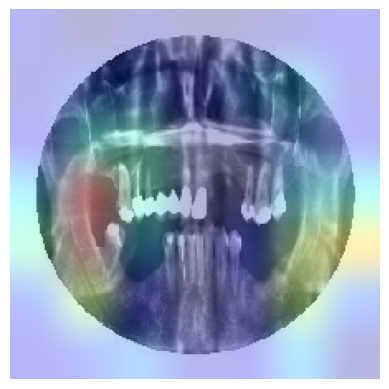

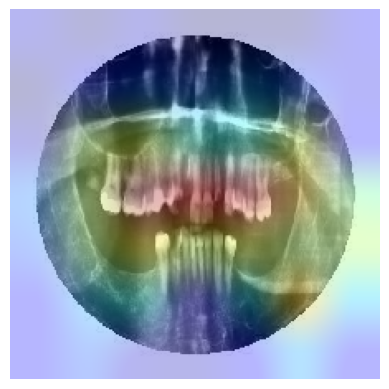

In [41]:
img = load_img(r"C:\Users\giannos\Desktop\AI\test\0507_jpg.rf.07ca548c6eb4f61c76f1629e7bc26fa4.jpg", target_size=(224, 224))
img_array = np.expand_dims(np.array(img), axis=0)
last_conv_layer_name = 'conv5_block3_out'  # last conv layer in the ResNet50
heatmap = gradcam_heatmap(img_array , res_model, last_conv_layer_name, 'class_output')


display_gradcam(img, heatmap)

img = load_img(r"C:\Users\giannos\Desktop\AI\test\0485_jpg.rf.09576812fc790cab5da2f6a5ceafe25f.jpg", target_size=(224, 224))
img_array = np.expand_dims(np.array(img), axis=0)

last_conv_layer_name = 'conv5_block3_out'  # last conv layer in the ResNet50
heatmap = gradcam_heatmap(img_array , res_model, last_conv_layer_name, 'class_output')

display_gradcam(img, heatmap)

In these heatmaps the regions highlighted in red and yellow indicate areas with the highest influence on the pre-trained ResNet model’s predictions. These areas likely contain features that the model associates strongly with specific conditions or classifications. The blue and green areas represent regions of lesser importance.

On the top image ('Fillings') the most intense regions of focus (red) are on the right side of the jaw, particularly around the molars and premolars. This can indicate where the model detects features associated with dental fillings. The red and yellow regions, particularly around the molars and premolars, suggest these teeth may have fillings or related dental work. This is where the model's attention is concentrated, likely because fillings often appear as distinct contrasts or shapes on X-rays compared to natural tooth structures.

On the bottom image ('Cavities') we see a broader distribution of highlighted areas, focusing on both the lower and upper teeth but prominently around the central teeth. This could suggest the presence of cavities which often develop in the crevices and between teeth common sites for plaque accumulation and decay.
The intense areas in the upper molars could be pointing towards more advanced decay or larger cavities, which are significant for the model’s classification decision.

As we can see the model showcases a pretty good ability to recognize the important areas of each picture and extract the important features. Even though it doesn't have really strong accuracy it can still detect and understand the health problem in each picture and showcase it. It is important to note that because the class 'Cavities' has a lot less samples than 'Fillings' we can see that the ResNet can't extract accurate features on the second image and has a broader distribution, in contrast with the first image that has recognized more accurately where the fillings are.

In [43]:
def preprocess_image(img):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0 
    return img

The preprocess_image function transforms the image in a normalized format that can pass through the model to produce the gradcam heatmap.

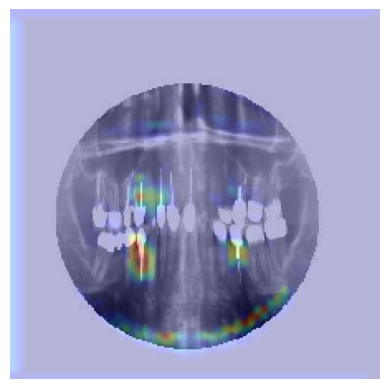

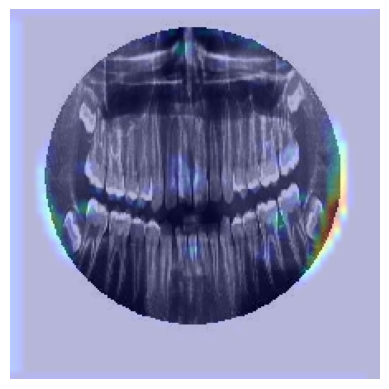

In [56]:


img = load_img(r"C:\Users\giannos\Desktop\AI\test\0794_jpg.rf.cc0c4ed7311e57db7eb6aa95d0dcbe47.jpg", target_size=(224, 224))
img_array = preprocess_image(img)
last_conv_layer_name = 'conv2d_5'  # last conv layer in the CNN
heatmap = gradcam_heatmap(img_array , custom_model, last_conv_layer_name, 'class_output')

display_gradcam(img, heatmap)

img = load_img(r"C:\Users\giannos\Desktop\AI\test\0060_jpg.rf.f094ea29e65bf0c78188acbcbc5c8dcd.jpg", target_size=(224, 224))
img_array = preprocess_image(img)

last_conv_layer_name = 'conv2d_5'  # last conv layer in the CNN
heatmap = gradcam_heatmap(img_array , custom_model, last_conv_layer_name, 'class_output')

display_gradcam(img, heatmap)

These visualizations highlight the areas of the X-rays where the custom CNN model focuses when predicting these specific conditions for two images.

On the first image which belongs to the class ('Fillings') the model highlights several regions around dental fillings, particularly on the right side of the mouth where there is a concentration of colors indicating high importance. These highlighted areas are likely locations where dental fillings are present, and the model's attention suggests it has learned to recognize features associated with restorative dental work.

The heatmap of the second image which belongs to the class ('Impacted Tooth') shows a more scattered and less intense pattern, primarily around the back molars. This diffuse highlighting indicates the model's attempt to identify impacted teeth, which are less distinct and more complex to diagnose from X-rays. 

The Fillings class benefits from a higher number of examples, allowing the model to learn detailed and specific features associated with fillings, leading to better predictive accuracy and focused heatmaps.
Conversely, the Impacted Tooth class, suffering from fewer examples, results in the model having a less focused and effective learning outcome. The model struggles to generalize well for this class, leading to broader and less accurate heatmap indications.